# STFT

https://courses.engr.illinois.edu/ece420/sp2019/lab3/STFT.pdf

# Phase vocoder

https://www.youtube.com/watch?v=h5o7jeddU0c
https://ww2.mathworks.cn/help/audio/ug/pitch-shifting-and-time-dilation-using-a-phase-vocoder-in-matlab.html
https://ww2.mathworks.cn/help/dsp/ref/dsp.stft.html

This is a direct application of STFT framework to perform time stretching w/o spectrum change.

It reveals how STFT framework works in programing language and also how it's applied to solve time stretching problem.

STFT uses hop length 64 but ISTFT uses 90, so every 64 more samples input would generate 90 more samples output, with window length 256.

from the code we can see:
 - STFT/ISTFT windows sizes are matched: both is set to be 256 (for 8KHz sample rate)
 - hop size is different so ISTFT generates longger time sequence
 - phase scaling is required to predict phase change at different ISTFT hop length.


```matlab
WindowLen = 256;
AnalysisLen = 64;
SynthesisLen = 90;
Hopratio = SynthesisLen/AnalysisLen;
unwrapdata = 2*pi*AnalysisLen*(0:WindowLen-1)'/WindowLen;
yangle = zeros(WindowLen,1);
firsttime = true;
...
while ~isDone(reader)
    y = reader();

    player(y); % Play back original audio

    % ST-FFT
    yfft = stft(y);
    
    % Convert complex FFT data to magnitude and phase.
    ymag       = abs(yfft);
    yprevangle = yangle;
    yangle     = angle(yfft);

    % Synthesis Phase Calculation
    % The synthesis phase is calculated by computing the phase increments
    % between successive frequency transforms, unwrapping them, and scaling
    % them by the ratio between the analysis and synthesis hop sizes.
    yunwrap = (yangle - yprevangle) - unwrapdata;
    yunwrap = yunwrap - round(yunwrap/(2*pi))*2*pi;
    yunwrap = (yunwrap + unwrapdata) * Hopratio;
    if firsttime
        ysangle = yangle;
        firsttime = false;
    else
        ysangle = ysangle + yunwrap;
    end

    % Convert magnitude and phase to complex numbers.
    ys = ymag .* complex(cos(ysangle), sin(ysangle));

    % IST-FFT
    yistfft = istft(ys);

    logger(yistfft) % Log signal 
end
```



## Re-implementation with python

The phase re-matching is based on relationship between delta phase & delta time:

$$
\varDelta \phi = \phi_{1} - \phi_{0} = 2\pi f t_{1} - 2\pi f t_{0} = 2\pi f (t_{1}-t_{0}) = 2\pi f \varDelta t
$$

so the predicted delta phase between output adjacent hop windows can be derived from delta phase between input adjacent hop windows as follow:
$$
\varDelta \phi_{output} = \varDelta \phi_{input} * \frac{hopLength_{out}}{hopLength_{in}}
$$

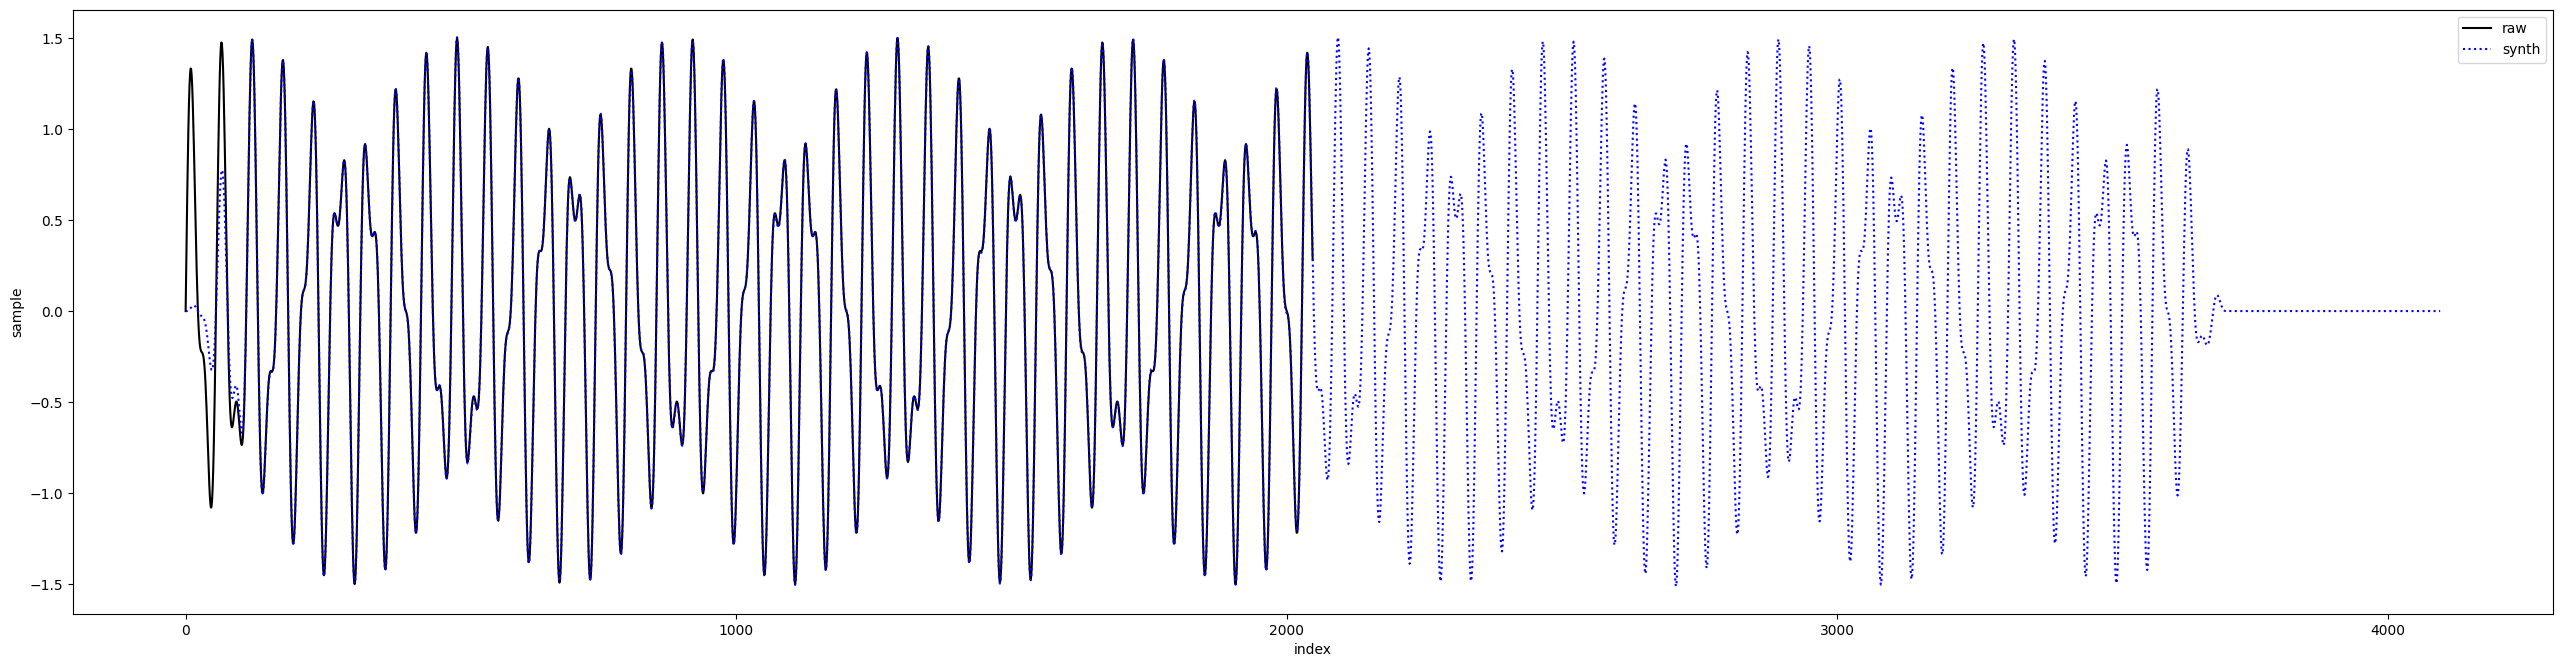

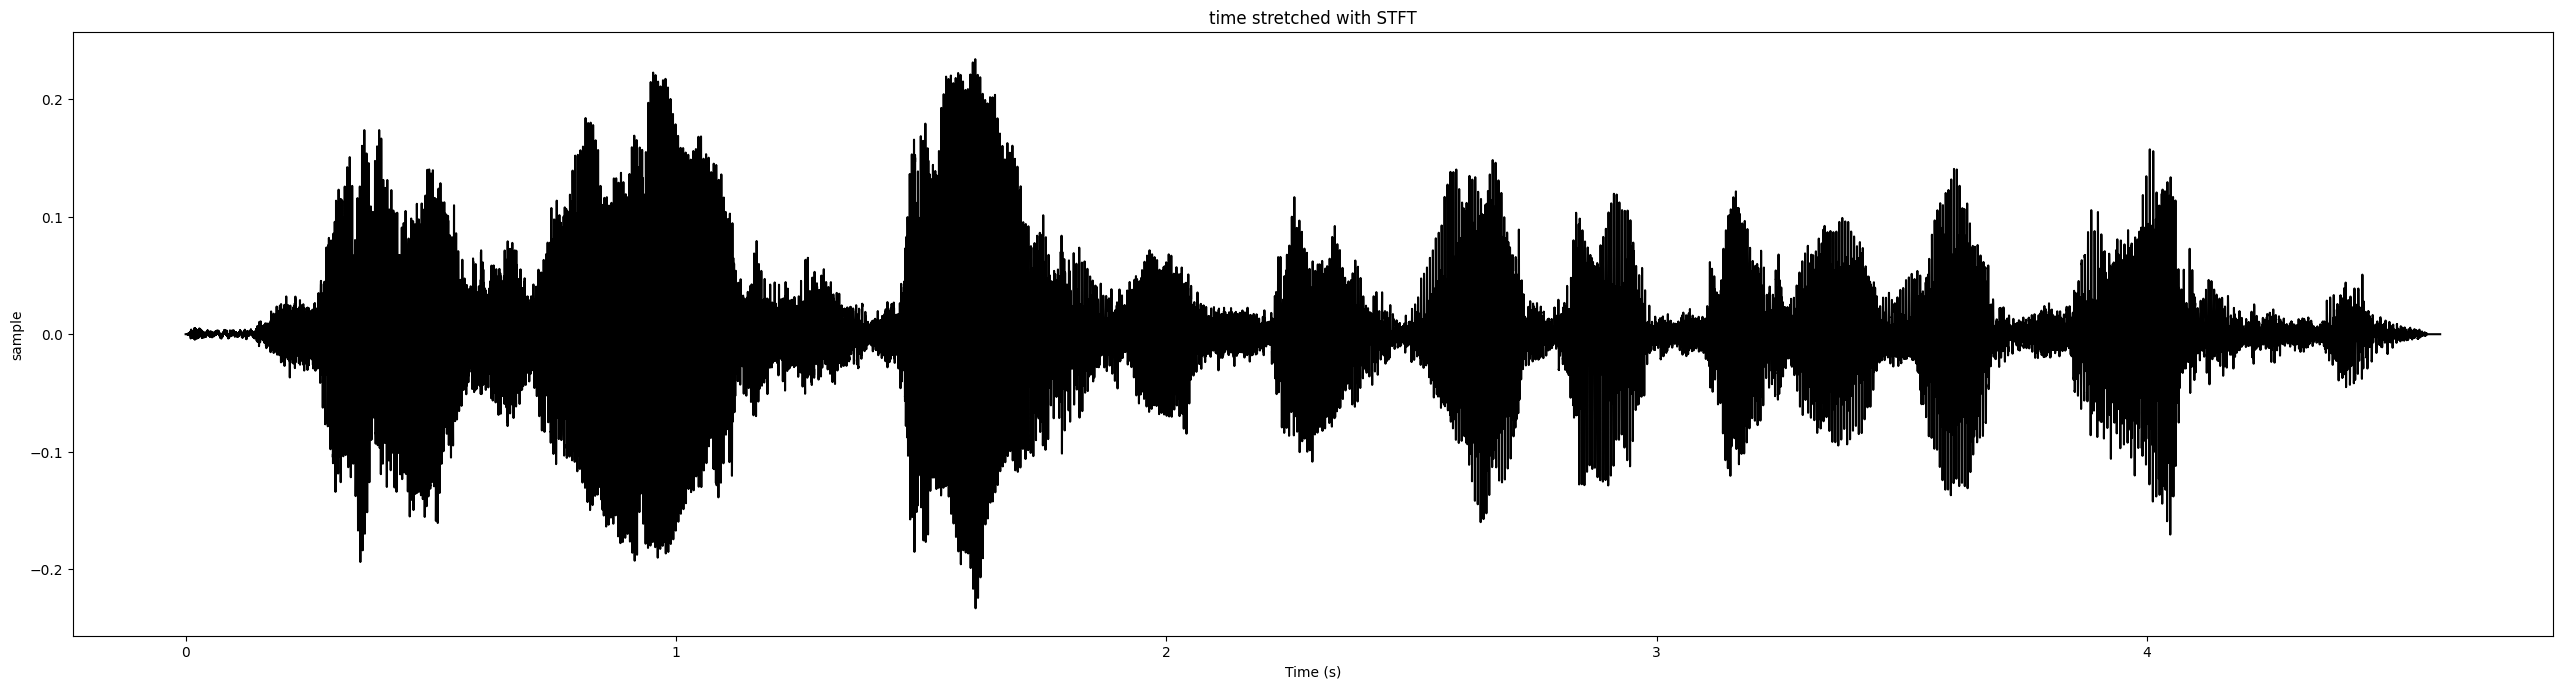

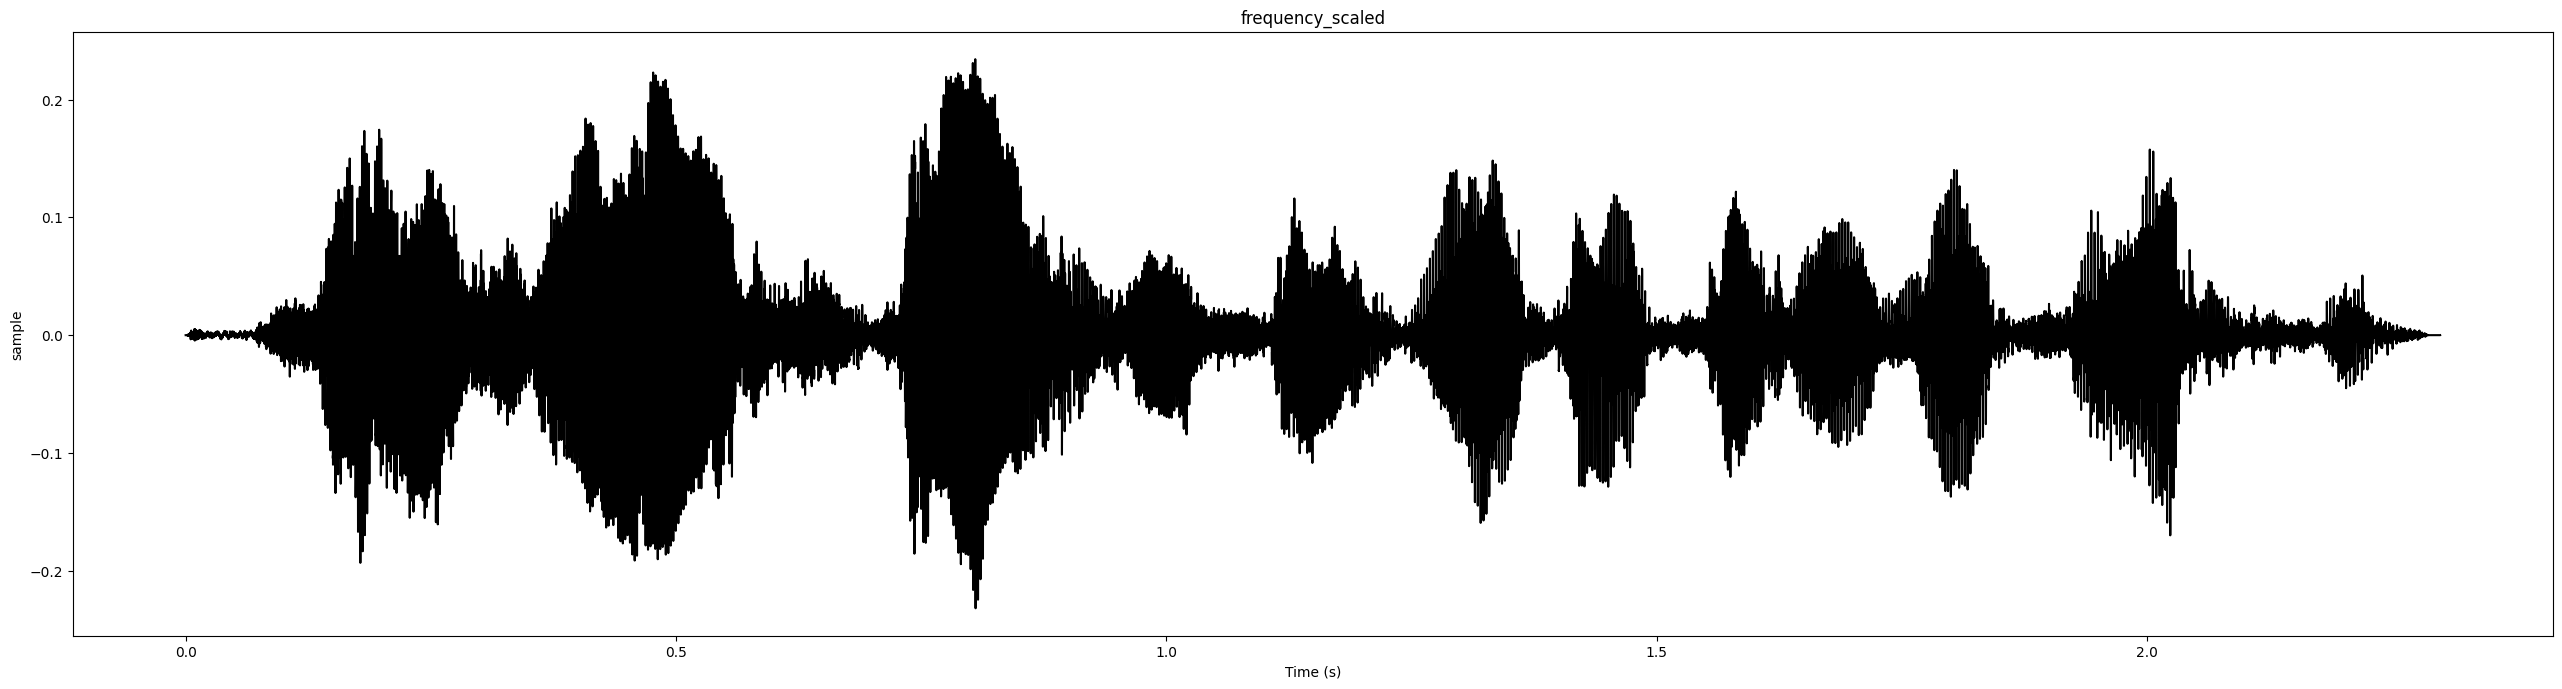

In [23]:
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import numpy as np
import IPython
import matplotlib.pyplot as plt
from vscode_audio import Audio
from lpc_helper import *
%matplotlib inline

class STFT:
    def __init__(self, windows_size, sample_rate, D):
        self.N = windows_size
        self.fs = sample_rate
        self.T = 1.0 / self.fs
        self.window = signal.windows.hann(self.N)
        self.window = self.window*D/np.sum(self.window)

    def stft(self, x):
        X = fft(x*self.window)
        return (np.abs(X), np.angle(X))

    def istft(self, xmag, xangle):
        return ifft(xmag * np.exp(1j*xangle))


def STFT_time_stretch(x, fs, wnd_size, hop_in, hop_out):
    stft = STFT(wnd_size, fs, hop_in)
    Nx = len(x)
    Ny = Nx*hop_out//hop_in
    y = np.zeros([Ny])

    phase_last = []
    phase_y = []
    i = k = 0
    while(i < Nx-wnd_size and k < Ny-wnd_size):
        ix = x[i:i+wnd_size]
        (mag, phase) = stft.stft(ix)

        if len(phase_last)==0:
            phase_last = phase
            phase_y = phase
        else:
            phase_delta = (phase - phase_last)
            phase_last = phase
            phase_y += phase_delta * (hop_out/hop_in)

        iy = stft.istft(mag, phase_y)
        y[k:k+wnd_size] += iy.real * (hop_out/hop_in)
        i += hop_in
        k += hop_out
    return y


wnd_size=256
fs = 8000
hop_in = 64
hop_out = 128

Nx = wnd_size*8
tx = np.linspace(0.0, Nx/fs, Nx, endpoint=False)
x = np.sin(150.0 * 2.0*np.pi*tx) + 0.5*np.sin(280.0 * 2.0*np.pi*tx)

y = STFT_time_stretch(x, fs, wnd_size, hop_in, hop_out)

plt.figure(figsize=(32,8), dpi=100, facecolor='w', edgecolor='k')
plt.plot(x, 'k-',label="raw")
plt.plot(y, 'b:',label="synth")
plt.legend()
plt.xlabel("index")
plt.ylabel("sample")

# now try a real sample
m0 = load_wave("wavs/m0.wav");
sr = 44100
time_stretched = STFT_time_stretch(m0, sr, 1024, 32, 64)
frequency_scaled = scipy.signal.resample(time_stretched, len(m0))

play_sound(time_stretched, rate=sr, name="time stretched with STFT", spectrum=-1)
play_sound(frequency_scaled, rate=sr, name="frequency_scaled", spectrum=-1)
